In [3]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Callable

newparams = {'figure.figsize': (12, 6), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

In [5]:
# Funksjon som løser en 4 dimensjonal diffrensialligning ved hjelp av Runge-Kutta sin metode av 4. orden. returnerer en liste
# med y verdier
# Parametre:
# F: funksjon som tar inn en liste med y verdier og en liste som y' skal lagres i
# y0: initialverdier til problemet, liste med 4 verdier
# h: lengden på tidssteg
def Runge_Kutta4(F: Callable[[np.ndarray, np.ndarray], np.void], y0: np.ndarray, h: float) -> np.ndarray:
    # Oppretter en matrise for å lagre midlertidige verdier
    F_vec = np.zeros((4, 4))
    
    # Oppretter en matrise for å lagre y verdier
    y_list = [y0]
    
    # Løkke for å lagre y verdier for alle tidsstegene
    while y_list[-1][2] >= 0:
        # Regner ut neste y verdi, og lagrer denne
        F(y_list[-1], F_vec[:,0])
        F(y_list[-1] + 0.5*h*F_vec[:,0], F_vec[:,1])
        F(y_list[-1] + 0.5*h*F_vec[:,1], F_vec[:,2])
        F(y_list[-1] + h*F_vec[:,2], F_vec[:,3])
        
        y_next = y_list[-1] + h*(1/6 * F_vec[:,0] + 1/3*F_vec[:,1] + 1/3 * F_vec[:,2]+1/6*F_vec[:,3])
        y_list.append(y_next)
    return np.array(y_list)

def xl_function(y_list):
    r = -y_list[-2, 2]/y_list[-1, 2]
    return 1/(r+1) * (y_list[-2, 0] + r*y_list[-1, 0])

def get_range(theta_list, v0, F_function, h, length_function = xl_function):
    range_list = []
    for theta in theta_list:
        y0 = np.array([0, v0*np.cos(theta), 0, v0*np.sin(theta)])
        y_list = Runge_Kutta4(F_function, y0, h)
        range_list.append(length_function(y_list))
    range_list = np.array(range_list)
    
    return range_list

In [6]:
def F_function_no_drag(y_list, dy_list, g=9.81):
    dy_list[0] = y_list[1]
    dy_list[1] = 0
    dy_list[2] = y_list[3]
    dy_list[3] = -g

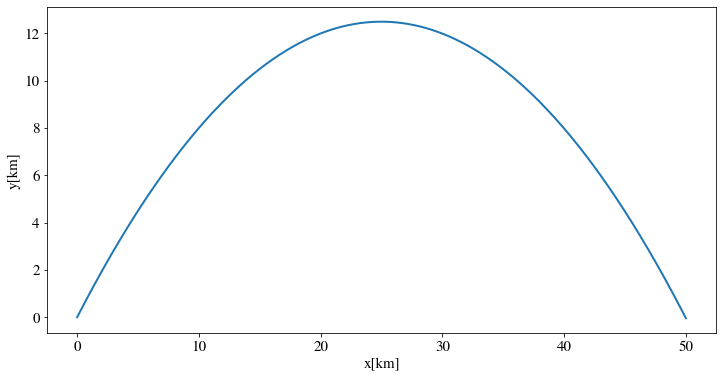

In [8]:
v0 = 700
theta0 = 45*np.pi/180

y0 = np.array([0, v0*np.cos(theta0), 0, v0*np.sin(theta0)])
h = 0.1
y_list: np.ndarray= Runge_Kutta4(F_function_no_drag, y0, h)
xl = xl_function(y_list)
plt.plot(y_list[:,0]/1000, y_list[:,2]/1000)
plt.xlabel("x[km]")
plt.ylabel("y[km]")
plt.show()